optimizing model with

In [ ]:
pip install torch

In [ ]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [ ]:
embedding_dims = 2
batch_size = 32
epochs = 40

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()

        if self.is_train:
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)

        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)

            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)

            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))

            return anchor_img, positive_img, negative_img, anchor_label

        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [ ]:
train_ds = MNIST(train_df,
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [ ]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [ ]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [ ]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Triplet Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 1/5 - Triplet Loss: 0.2262


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 2/5 - Triplet Loss: 0.0979


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 3/5 - Triplet Loss: 0.0750


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 4/5 - Triplet Loss: 0.0661


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 5/5 - Triplet Loss: 0.0558


In [ ]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

In [ ]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/1313 [00:00<?, ?it/s]

(42000, 2)

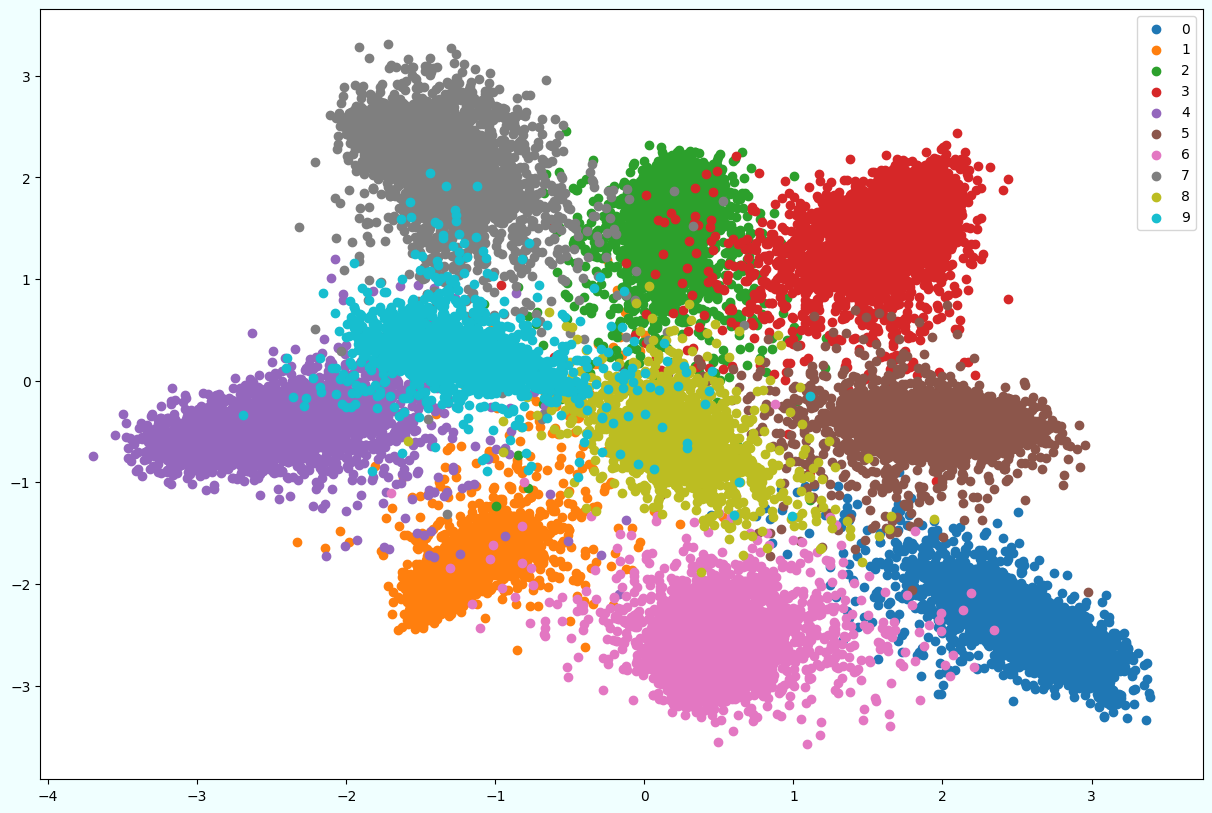

In [ ]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

Triplet MarginLoss Function

In [ ]:
import torch

In [ ]:
print(torch.__version__)

In [ ]:
import torch.nn as nn

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
anchor = torch.randn(100, 128, requires_grad=True)
pos = torch.randn(100, 128, requires_grad=True)
neg = torch.randn(100, 128, requires_grad=True)
result = triplet_loss(anchor, pos, neg)
result.backward()
result

tensor(1.0716, grad_fn=<MeanBackward0>)

Built-in Distance Function

In [ ]:
embedding = nn.Embedding(1000, 128)
anchor_ids = torch.randint(0, 1000, (1,))
pos_ids = torch.randint(0, 1000, (1,))
neg_ids = torch.randint(0, 1000, (1,))
anchor = embedding(anchor_ids)
pos = embedding(pos_ids)
neg = embedding(neg_ids)

triplet_loss = \
    nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance())
result = triplet_loss(anchor, pos, neg)
result

tensor(0.5646, grad_fn=<MeanBackward0>)

Custom Distance Function

In [ ]:
def l_infinity(x1, x2):
    return torch.max(torch.abs(x1 - x2), dim=1).values
triplet_loss = (
    nn.TripletMarginWithDistanceLoss(distance_function=l_infinity, margin=1.5))
result = triplet_loss(anchor, pos, neg)
result

tensor(1.3835, grad_fn=<MeanBackward0>)